In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Custom Model (MobileNetV3 Backbone)

In [ ]:
!pip install gtts

In [ ]:
# Directory and progress handling
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

# Handle warnings
import warnings
warnings.filterwarnings('ignore')

# Data visulization
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# listen to predicted text
from gtts import gTTS
from IPython.display import Audio, display

# Text and Image proceesing and modeling
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3  import preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add,Bidirectional
from tensorflow.keras.layers import BatchNormalization, RepeatVector, Dot, Activation,Concatenate
from tensorflow.keras.optimizers import Adam

2024-12-31 12:54:38.822951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
BASE_DIR = '/Users/kashish/Desktop/Kashish/College/SEM III/CSE 575-Statistical Machine Learning/Project/image_captioning/dataset'
WORKING_DIR = '/Users/kashish/Desktop/Kashish/College/SEM III/CSE 575-Statistical Machine Learning/Project/image_captioning'

In [ ]:
BASE_DIR = '/content/drive/Othercomputers/My Mac/College/SEM III/CSE 575-Statistical Machine Learning/Project/image_captioning/dataset'
WORKING_DIR = '/content/drive/Othercomputers/My Mac/College/SEM III/CSE 575-Statistical Machine Learning/Project/image_captioning'

In [ ]:
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
# List of image filenames
image_filenames = os.listdir(IMAGES_DIR)
# Select 12 images for display
image_filenames = image_filenames[:12]
fig, axes = plt.subplots(2, 6, figsize=(15, 6)) #12 image in 2 rows and 6 columns
fig.tight_layout(pad=3.0)
# Display images without captions
for i, ax in enumerate(axes.flat):
    # Load the image
    img_path = os.path.join(IMAGES_DIR, image_filenames[i])
    img = Image.open(img_path)
    # Display the image
    ax.imshow(img)
    ax.axis('off')  # Hide axes and captions
plt.show()

In [ ]:
# load MobileNetV3Large model

model = MobileNetV3Large(weights='imagenet', include_top=True)

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summarize the model for checking the last layer

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')  # Path to the directory containing images
# Loop through all images in the directory
for img_name in tqdm(os.listdir(directory)):
    # Load the image with the target size of 224x224 (required for ---->MobileNetV3Large<----)
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image to a numpy array
    image = img_to_array(image)
    # Expand dimensions to match the model's expected input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    # Preprocess the image for MobileNetV3Large
    image = preprocess_input(image)
    # Extract features from the second-to-last fully connected layer
    feature = model.predict(image, verbose=0)
    # Get the image ID (filename without extension)
    image_id = img_name.split('.')[0]
    # Store the extracted features in the dictionary
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle file ! ...to use it instead of the last code of feature extraction again
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle, if you have the file you can start from here

with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    # to skip the first row on the captions file
    next(f)
    # read all captions file
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions

mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if image ID will added to the first time
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption if the image ID already exting in the mapping dict
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

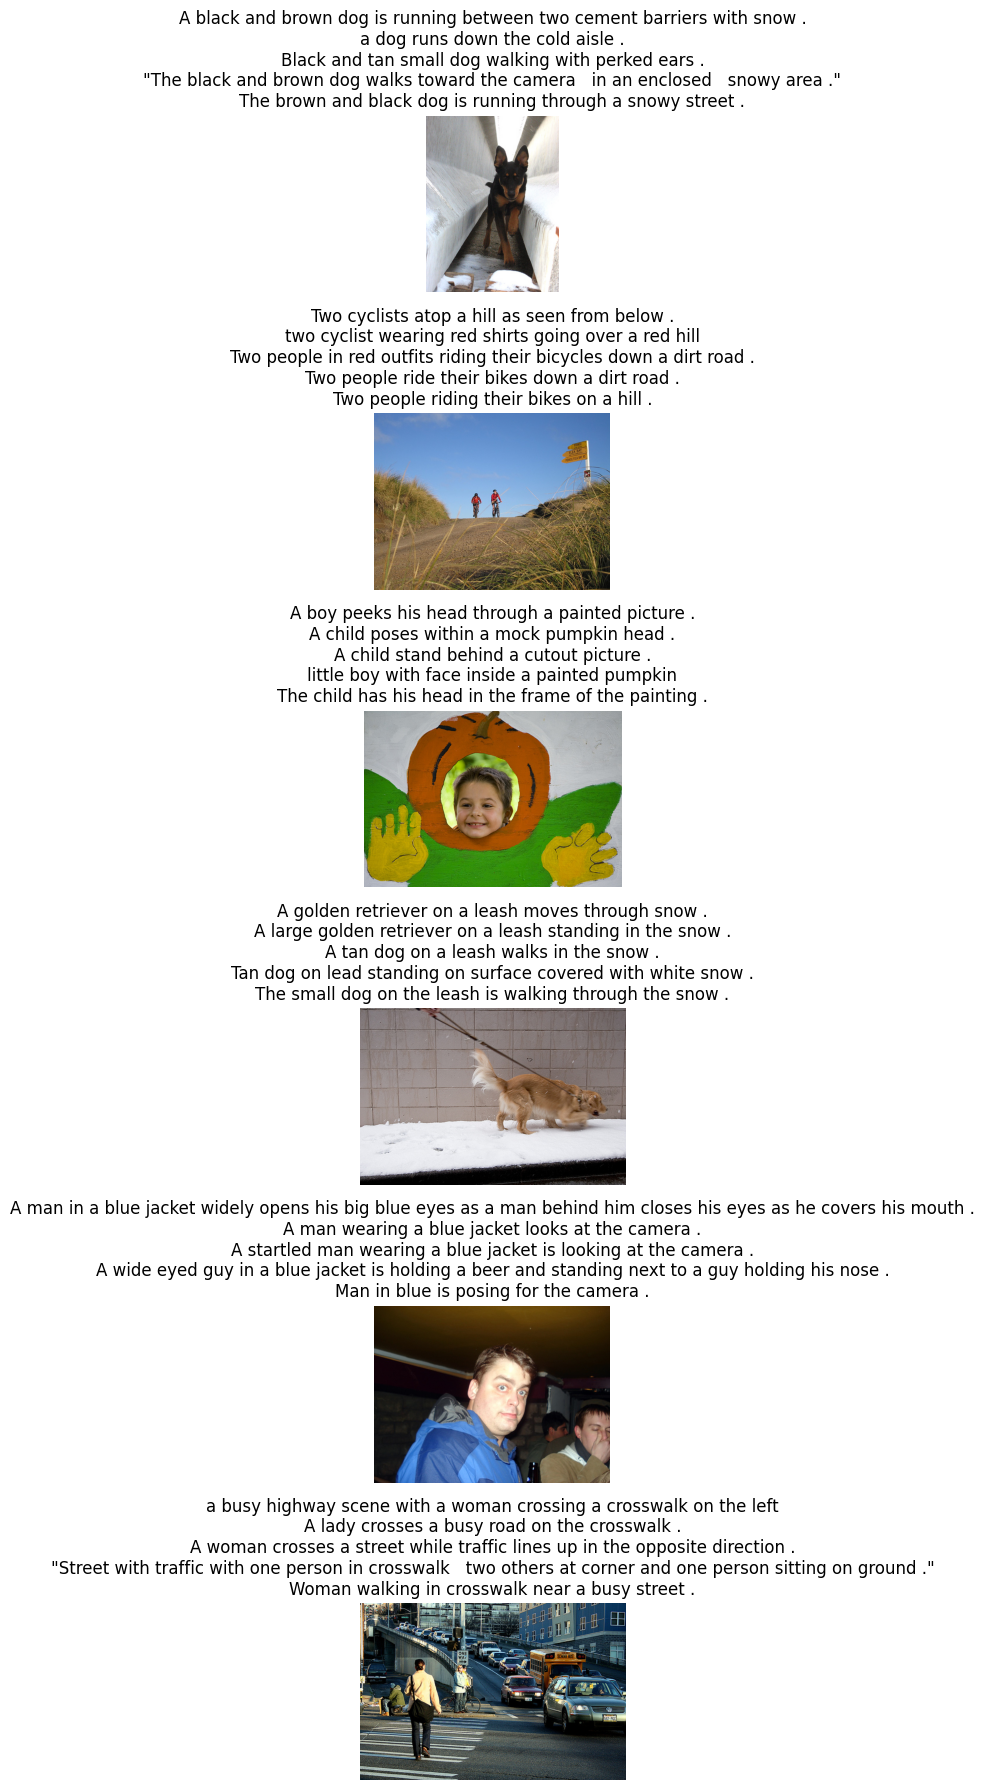

In [ ]:
# after preparing the captions , we will display a sample of the data with captions

def display_images_with_mapping(directory, mapping, num_images=6):
    # Get all image filenames from the directory
    img_names = os.listdir(directory)[:num_images]  # to get 6 images ..note if you want to display more handle the num of images
    # Create a figure with 6 rows (one for each image) and 1 column
    fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 3))

    for i, img_name in enumerate(img_names):
        # Extract image ID by removing file extension
        image_id = img_name.split('.')[0]
        # Ensure the image ID is in the mapping dictionary
        if image_id in mapping:
            # Load the image
            img_path = os.path.join(directory, img_name)
            img = plt.imread(img_path)
        # Plot the image in the corresponding row
            axes[i].imshow(img)
            axes[i].axis('off')  # Hide axis for a cleaner look
            # Get the corresponding captions from the mapping
            captions = mapping[image_id][:5]  # Get the first 5 captions
            caption_text = "\n".join(captions)
            axes[i].set_title(caption_text, fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Directory containing images
image_directory = os.path.join(BASE_DIR, 'Images')
# Call the function to display images with captions
display_images_with_mapping(image_directory, mapping)

In [ ]:
def clean_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption ---> important in text generation
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text

mapping['1032122270_ea6f0beedb']

['A woman crouches near three dogs in a field .',
 'Three dogs are playing on grassy hill with a blue sky .',
 'Three dogs are standing in the grass and a person is sitting next to them',
 'Three dogs on a grassy hill',
 'Three dogs stand in a grassy field while a person kneels nearby .']

In [ ]:
clean_captions(mapping)

In [ ]:
# after preprocess of text
mapping['1032122270_ea6f0beedb']

['startseq woman crouches near three dogs in field endseq',
 'startseq three dogs are playing on grassy hill with blue sky endseq',
 'startseq three dogs are standing in the grass and person is sitting next to them endseq',
 'startseq three dogs on grassy hill endseq',
 'startseq three dogs stand in grassy field while person kneels nearby endseq']

In [ ]:
all_captions = []

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kashish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


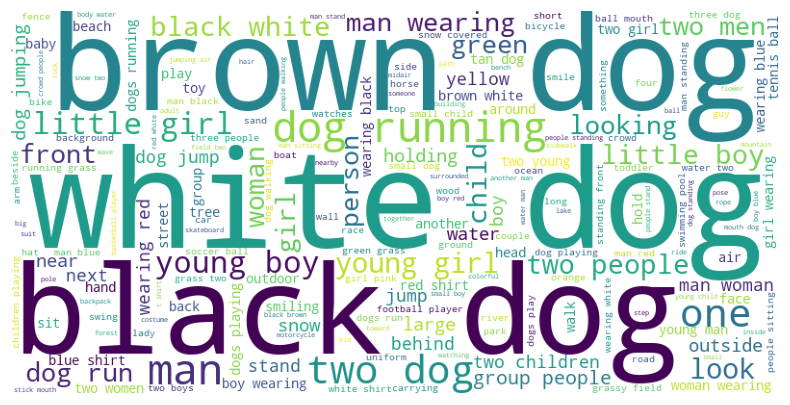

In [ ]:
# the importance of this step to know the most frequant words in your dataset
# Download stopwords
nltk.download('stopwords')

# Remove 'startseq' and 'endseq' from captions
filtered_captions = [caption.replace('startseq', '').replace('endseq', '') for caption in all_captions]

# Combine all captions into one string
all_text = " ".join(filtered_captions)

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_text.split() if word not in stop_words]

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [ ]:
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

In [ ]:
# prepare a list of image IDs
image_ids = list(mapping.keys())

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    # Ensure padding is applied properly here
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0


In [ ]:
#Model Architecture
inputs1 = Input(shape=(1000,),name='image')
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
fe2_projected = RepeatVector(max_length)(fe2)

inputs2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

attention = Dot(axes=[2, 2])([fe2_projected, se3])
attention = Activation('softmax')(attention)
context_vector = Dot(axes=[1, 1])([attention, se3])
context_vector = BatchNormalization()(context_vector)


context_vector = tf.keras.layers.Flatten()(context_vector)
decoder1 = Concatenate()([context_vector, fe2])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=5e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Model training from the data generator

epochs = 2
batch_size = 32
steps = len(image_ids) // batch_size
for i in range(epochs):
    generator = data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2024-11-11 14:36:15.139348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-11 14:36:16.634240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-11-11 14:36:18.508160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'g

252/252 [==============================] - 1322s 5s/step - loss: 4.7431 - accuracy: 0.2263


2024-11-11 14:58:17.326006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


252/252 [==============================] - 1361s 5s/step - loss: 3.5699 - accuracy: 0.3144


In [ ]:
model.save('best.keras')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=1090b56d6c003a3160eb6354a49e77a7c3e2cdd989a76516fdbb8ee179157514
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_rouge(pred_caption, true_caption):
    # Compute ROUGE scores
    scores = scorer.score(true_caption, pred_caption)
    return scores

In [ ]:
# generate caption for an image

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length,padding='post')
        # predict next word in the sentence
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability of the next word
        yhat = np.argmax(yhat)
        # convert index to word (look at the function above)
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
def generate_caption_and_score(image_name, true_caption):
    # Extract image ID
    image_id = image_name.split('.')[0]

    # Load the image file
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    # Generate the predicted caption
    # pred_caption = predict_caption(model, features[image_id], tokenizer, max_length)
    pred_caption = mapping[image_name.replace('.jpg', '')][1]
    pred_caption_text = pred_caption.replace('startseq', '').replace('endseq', '').strip()

    true_caption_text = true_caption.replace('startseq', '').replace('endseq', '').strip()

    # Calculate ROUGE score with the true caption
    rouge_scores = compute_rouge(mapping[image_name.replace('.jpg', '')][1], true_caption)

    # Display the predicted caption and ROUGE scores
    print('True Caption:', true_caption_text)
    print("Predicted Caption:", pred_caption_text)
    for score in rouge_scores:
        print(f"{score}: {rouge_scores[score]}")

    # Display the image
    plt.axis('off')
    plt.imshow(image)
    plt.show()

True Caption: black and white dog standing on its hind legs on carpeting in front of chair
Predicted Caption: black and white dog stands on its hind legs
rouge1: Score(precision=1.0, recall=0.6470588235294118, fmeasure=0.7857142857142858)
rouge2: Score(precision=0.9, recall=0.5625, fmeasure=0.6923076923076923)
rougeL: Score(precision=1.0, recall=0.6470588235294118, fmeasure=0.7857142857142858)


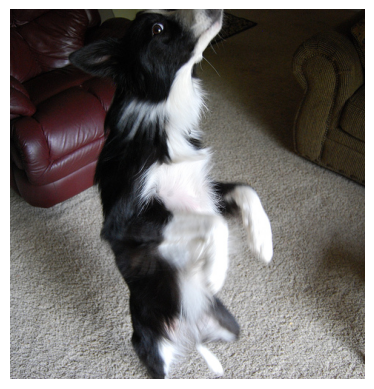

True Caption: "a boy holding toy football runs along paved path ."
Predicted Caption: boy runs past house carrying very small plastic foam football
rouge1: Score(precision=0.4166666666666667, recall=0.45454545454545453, fmeasure=0.43478260869565216)
rouge2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
rougeL: Score(precision=0.3333333333333333, recall=0.36363636363636365, fmeasure=0.34782608695652173)


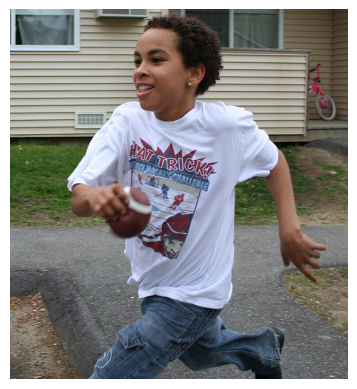

True Caption: race car coming around curve on gravel course creating lots of dust
Predicted Caption: race car with cloud of dust behind it
rouge1: Score(precision=0.6, recall=0.42857142857142855, fmeasure=0.5)
rouge2: Score(precision=0.3333333333333333, recall=0.23076923076923078, fmeasure=0.27272727272727276)
rougeL: Score(precision=0.6, recall=0.42857142857142855, fmeasure=0.5)


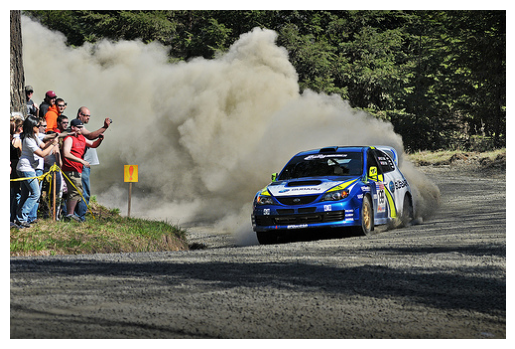

In [ ]:
# choose random 3 images to get the captions of them

images_path = os.listdir(os.path.join(BASE_DIR,'Images'))
# image_name_idx = np.random.randint(0,8000,3)

image_name_idx = np.array([7750, 434, 2610])

for i in image_name_idx:
    generate_caption_and_score(images_path[i], mapping[images_path[i].replace('.jpg','')][0])

array([7750, 4800, 3589])

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load the BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
blip_captions = []

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

True Caption: black and white dog standing on its hind legs on carpeting in front of chair
BLIP Caption: a dog standing on its hinds on the floor
rouge1: Score(precision=0.6666666666666666, recall=0.4, fmeasure=0.5)
rougeL: Score(precision=0.6666666666666666, recall=0.4, fmeasure=0.5)


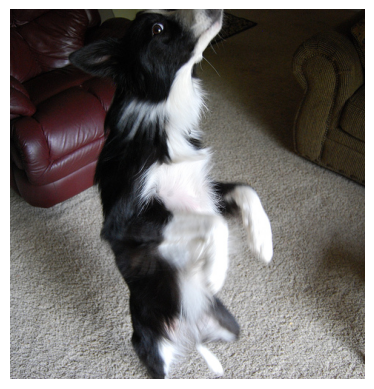

----------
True Caption: "a boy holding toy football runs along paved path ."
BLIP Caption: a young boy playing with a frc
rouge1: Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25)
rougeL: Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25)


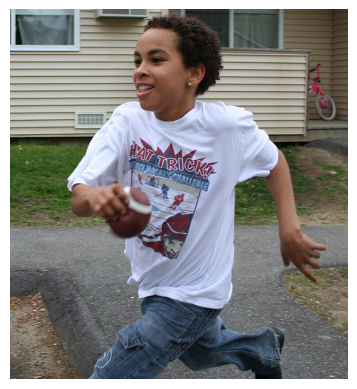

----------
True Caption: race car coming around curve on gravel course creating lots of dust
BLIP Caption: a car is driving on a dirt road
rouge1: Score(precision=0.25, recall=0.16666666666666666, fmeasure=0.2)
rougeL: Score(precision=0.25, recall=0.16666666666666666, fmeasure=0.2)


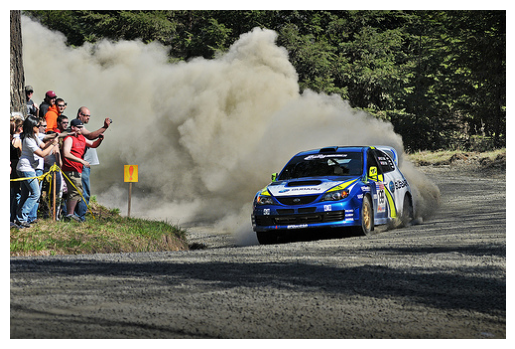

----------


In [ ]:
for i in image_name_idx:

    # Load and process the image
    image = Image.open(os.path.join(BASE_DIR,'Images',images_path[i]))
    inputs = processor(image, return_tensors="pt")

    # Generate caption
    output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)


    print("True Caption:", mapping[images_path[i].replace('.jpg','')][0].replace('startseq', '').replace('endseq', '').strip())
    print("BLIP Caption:", caption)

    rouge_scores = compute_rouge(caption, mapping[images_path[i].replace('.jpg','')][0].replace('startseq', '').replace('endseq', '').strip())
    for score in rouge_scores:
      if score != 'rouge2':
        print(f"{score}: {rouge_scores[score]}")

    blip_captions.append(caption)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print('----------')